In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
os.getcwd()
os.chdir('gdrive')
os.chdir('My Drive')
os.chdir('DeepResection')

!ls

In [ ]:
! pip install git+https://github.com/qubvel/segmentation_models

After navigating to the right directory, implement the data preprocessing/generating code

In [ ]:
import numpy as np
import glob
import os
import keras
from PIL import Image
import shutil

def getListOfImagePaths(dirPath):
    imagePaths = glob.glob('data/png/*/img/*')
    ret = [os.path.join(dirPath, os.path.normpath(path)) for path in imagePaths]
    return ret

def getListOfMaskPaths(imagePaths):
    ret = [p.replace('img/', 'mask/') for p in imagePaths]
    return ret

def adjust_sizes(img_arr, dim = (256, 256)):
    if(img_arr.shape[0] < dim[0]):
        toBeAdded = dim[0] - img_arr.shape[0]
        toBeAdded1 = int(np.ceil(toBeAdded/2))
        toBeAdded2 = int(np.floor(toBeAdded/2))
        img_arr = np.pad(img_arr, ((toBeAdded1, toBeAdded2), (0, 0)))
    elif(img_arr.shape[0] > dim[0]):
        toBeRemoved = img_arr.shape[0]-dim[0]
        toBeRemoved1 = int(np.ceil(toBeRemoved/2))
        toBeRemoved2 = int(np.floor(toBeRemoved/2))
        index1 = toBeRemoved1
        index2 = img_arr.shape[0]-toBeRemoved2
        img_arr = img_arr[index1:index2,:]
    if(img_arr.shape[1] < dim[1]):
        toBeAdded = dim[1] - img_arr.shape[1]
        toBeAdded1 = int(np.ceil(toBeAdded/2))
        toBeAdded2 = int(np.floor(toBeAdded/2))
        img_arr = np.pad(img_arr, ((0, 0), (toBeAdded1, toBeAdded2)))
    elif(img_arr.shape[1] > dim[1]):
        toBeRemoved = img_arr.shape[1]-dim[1]
        toBeRemoved1 = int(np.ceil(toBeRemoved/2))
        toBeRemoved2 = int(np.floor(toBeRemoved/2))
        index1 = toBeRemoved1
        index2 = img_arr.shape[1]-toBeRemoved2
        img_arr = img_arr[:,index1:index2]
    return img_arr

# dim is a tuple: (256, 256)
def getImagesForClassification(imagePaths, dim=(256, 256)):
    ret = np.empty((len(imagePaths), dim[0], dim[1], 3))
    index = 0
    for path in imagePaths:
        img = Image.open(path)
        img_arr = np.asarray(img)
        img_arr = adjust_sizes(img_arr, dim)
        #add image to returned array
        ret[index,:,:,0] = img_arr
        ret[index,:,:,1] = img_arr
        ret[index,:,:,2] = img_arr
        index=index+1
    return ret

# returns numpy vector where each entry is 0 or 1 based on whether the image contains resected tissue
def getClassificationY(maskPaths, dim=(256, 256)):
    num_masks = len(maskPaths)
    Y = np.zeros(num_masks)
    index = 0
    for path in maskPaths:
        img = Image.open(path)
        img_arr = np.asarray(img)
        #pad image
        img_arr = adjust_sizes(img_arr, dim)
        Y[index] = 1 if np.any(img_arr) else 0
        index=index+1
    return Y

# dim is a tuple: (256, 256)
def getImagesForSegmentation(imagePaths, dim=(256,256)):
    ret = np.empty((len(imagePaths), dim[0], dim[1]))
    index = 0
    for path in imagePaths:
        img = Image.open(path)
        img_arr = np.asarray(img)
        #pad image
        img_arr = adjust_sizes(img_arr, dim)
        #add image to returned array
        ret[index,:,:] = img_arr
        index=index+1
    return ret


#dirPath = os.getcwd()
#imagePaths = getListOfImagePaths(dirPath)
#maskPaths = getListOfMaskPaths(imagePaths)

# define the training, validation, and test patients
#imagePaths_valid = []
#for path in imagePaths:
#    if '14_w' in path or '23_r' in path or '27_m' in path or 'pat05' in path or 'pat11' in path or 'pat15' in path or 'pat20' in path or 'HUP041' in path or 'HUP045' in path or 'HUP049' in path or 'HUP052' in path or 'HUP054' in path or 'HUP056' in path:
#        imagePaths_valid.append(path)
#maskPaths_valid = getListOfMaskPaths(imagePaths_valid)
#imagePaths_test = []
#for path in imagePaths:
#    if '24_c' in path or '40_f' in path or '42_m' in path or 'pat03' in path or 'pat06' in path or 'pat25' in path or 'pat30' in path or 'HUP057' in path or 'HUP058' in path or 'HUP060' in path or 'HUP064' in path or 'HUP065' in path:
#        imagePaths_test.append(path)
#maskPaths_test = getListOfMaskPaths(imagePaths_test)
#imagePaths_train = []
#for path in imagePaths:
#    if path not in imagePaths_valid and path not in imagePaths_test:
#        imagePaths_train.append(path)
#maskPaths_train = getListOfMaskPaths(imagePaths_train)

#for path in imagePaths_train:
#    pat_id = (path.split('png/')[1]).split('/img')[0]
#    new_name = os.path.basename(path)
#    new_name = new_name.replace('img_', "%s_img_" % pat_id)
#    new_file = "train/images/all_images/%s" % new_name
#    if(not os.path.exists(new_file)):
#        shutil.copyfile(path, new_file)

#for path in maskPaths_train:
#    if('(1)' not in path):
#      pat_id = (path.split('png/')[1]).split('/mask')[0]
#      new_name = os.path.basename(path)
#      new_name = new_name.replace('img_', "%s_img_" % pat_id)
#      new_file = "train/masks/all_images/%s" % new_name
#      if(not os.path.exists(new_file)):
#          shutil.copyfile(path, new_file)

#for path in imagePaths_valid:
#    if('(1)' not in path):
#      pat_id = (path.split('png/')[1]).split('/img')[0]
#      new_name = os.path.basename(path)
#      new_name = new_name.replace('img_', "%s_img_" % pat_id)
#      new_file = "validation/images/all_images/%s" % new_name
#      if(not os.path.exists(new_file)):
#          shutil.copyfile(path, new_file)

#for path in maskPaths_valid:
#    if('(1)' not in path):
#      pat_id = (path.split('png/')[1]).split('/mask')[0]
#      new_name = os.path.basename(path)
#      new_name = new_name.replace('img_', "%s_img_" % pat_id)
#      new_file = "validation/masks/all_images/%s" % new_name
#      if(not os.path.exists(new_file)):
#          shutil.copyfile(path, new_file)

#for path in imagePaths_test:
#    if('(1)' not in path):
#        pat_id = (path.split('png/')[1]).split('/img')[0]
#        new_name = os.path.basename(path)
#        new_name = new_name.replace('img_', "%s_img_" % pat_id)
#        new_file = "test/images/all_images/%s" % new_name
#        if(not os.path.exists(new_file)):
#            shutil.copyfile(path, new_file)

#for path in maskPaths_test:
#    if('(1)' not in path):
#      pat_id = (path.split('png/')[1]).split('/mask')[0]
#      new_name = os.path.basename(path)
#      new_name = new_name.replace('img_', "%s_img_" % pat_id)
#      new_file = "test/masks/all_images/%s" % new_name
#      if(not os.path.exists(new_file)):
#          shutil.copyfile(path, new_file)


Load the virtual lesion data

In [ ]:
import numpy as np
import glob
import os
import keras
from PIL import Image
import shutil

def getListOfImagePaths(dirPath):
    imagePaths = glob.glob('png_3dims/*/img/*.png')
    ret = [os.path.join(dirPath, os.path.normpath(path)) for path in imagePaths]
    return ret

def getListOfMaskPaths(imagePaths):
    ret = [p.replace('img/', 'mask/') for p in imagePaths]
    return ret


dirPath = os.getcwd()
imagePaths = getListOfImagePaths(dirPath)
maskPaths = getListOfMaskPaths(imagePaths)

# define the training, validation, and test patients
imagePaths_valid = []
imagePaths_test = []
imagePaths_train = []
train_id = []
valid_id = []
test_id = []
for path in imagePaths:
    pat_id = (path.split('png_3dims/')[1]).split('/img')[0]
    if 'HUP' in pat_id:
        pat_id = pat_id.split('_')[0]
    else:
        pat_id = pat_id.split('_dim')[0]
    if pat_id in ('14_w', '23_r', '27_m', 'pat05', 'pat11', 'pat15', 'pat20', 'HUP041', 'HUP045', 'HUP058', 'HUP052', 'HUP054', 'HUP056', 'HUP098', 'HUP148'):
        imagePaths_valid.append(path)
        if pat_id not in valid_id:
            valid_id.append(pat_id)
    elif pat_id in ('24_c', '40_f', '42_m', 'pat03', 'pat06', 'pat25', 'pat30', 'HUP057', 'HUP060', 'HUP064', 'HUP065', 'HUP181', 'HUP142'):
        imagePaths_test.append(path)
        if pat_id not in test_id:
            test_id.append(pat_id)
    else:
        imagePaths_train.append(path)
        if pat_id not in train_id:
            train_id.append(pat_id)
maskPaths_valid = getListOfMaskPaths(imagePaths_valid)
maskPaths_test = getListOfMaskPaths(imagePaths_test)
maskPaths_train = getListOfMaskPaths(imagePaths_train)

#print('1')

#for path in imagePaths_train:
#    pat_id = (path.split('png_3dims/')[1]).split('/img/')[0]
#    new_name = os.path.basename(path)
#    new_name = new_name.replace('img_', "%s_img_" % pat_id)
#    new_file = "train_3d/images/all_images/%s" % new_name
#    if not os.path.exists(new_file):
#        shutil.copy2(path, new_file)

print('2')

for path in maskPaths_train:
    pat_id = (path.split('png_3dims/')[1]).split('/mask/')[0]
    new_name = os.path.basename(path)
    new_name = new_name.replace('img_', "%s_img_" % pat_id)
    new_file = "train_3d/masks/all_images/%s" % new_name
    shutil.copy2(path, new_file)

#print('3')

#for path in imagePaths_valid:
#    pat_id = (path.split('png_3dims/')[1]).split('/img/')[0]
#    new_name = os.path.basename(path)
#    new_name = new_name.replace('img_', "%s_img_" % pat_id)
#    new_file = "validation_3d/images/all_images/%s" % new_name
#    if not os.path.exists(new_file):
#        shutil.copy2(path, new_file)

#print('4')

#for path in maskPaths_valid:
#    pat_id = (path.split('png_3dims/')[1]).split('/mask/')[0]
#    new_name = os.path.basename(path)
#    new_name = new_name.replace('img_', "%s_img_" % pat_id)
#    new_file = "validation_3d/masks/all_images/%s" % new_name
#    if not os.path.exists(new_file):
#        shutil.move(path, new_file)

#print('5')

#for path in imagePaths_test:
#    pat_id = (path.split('png_3dims/')[1]).split('/img/')[0]
#    new_name = os.path.basename(path)
#    new_name = new_name.replace('img_', "%s_img_" % pat_id)
#    new_file = "test_3d/images/all_images/%s" % new_name
#    if not os.path.exists(new_file):
#        shutil.copy2(path, new_file)

print('6')

#for path in maskPaths_test:
#    pat_id = (path.split('png_3dims/')[1]).split('/mask/')[0]
#    new_name = os.path.basename(path)
#    new_name = new_name.replace('img_', "%s_img_" % pat_id)
#    new_file = "test_3d/masks/all_images/%s" % new_name
#    if not os.path.exists(new_file):
#        shutil.copy2(path, new_file)

In [ ]:
list_im = os.listdir('test_3d/images/all_images')
list_mask = os.listdir('test_3d/masks/all_images')

for path in list_im:
    if path not in list_mask:
        path_new = os.path.join('test_3d/images/all_images/', path)
        os.remove(path_new)

Save dataset to npy files

In [ ]:
#np.save('X_train_class.npy', X_train_class)
#np.save('Y_train_class.npy', Y_train_class)
#np.save('X_valid_class.npy', X_valid_class)
#np.save('Y_valid_class.npy', Y_valid_class)
#np.save('X_test_class.npy', X_test_class)
#np.save('Y_test_class.npy', Y_test_class)

#np.save('X_train_seg.npy', X_train_seg)
#np.save('Y_train_seg.npy', Y_train_seg)
#np.save('X_valid_seg.npy', X_valid_seg)
#np.save('Y_valid_seg.npy', Y_valid_seg)
#np.save('X_test_seg.npy', X_test_seg)
#np.save('Y_test_seg.npy', Y_test_seg)

np.save('X_valid_seg_more.npy', X_valid_seg)
np.save('Y_valid_seg_more.npy', Y_valid_seg)
#np.save('X_valid_seg.npy', X_valid_seg)
#np.save('Y_valid_seg.npy', Y_valid_seg)
#np.save('X_test_seg.npy', X_test_seg)
#np.save('Y_test_seg.npy', Y_test_seg)

Load dataset from npy files

In [ ]:
import numpy as np

#X_train_seg = np.load('X_train_seg.npy')
#Y_train_seg = np.load('Y_train_seg.npy')
X_valid_seg = np.load('X_valid_seg_more.npy')
Y_valid_seg = np.load('Y_valid_seg_more.npy')
X_test_seg = np.load('X_test_seg_more.npy')
Y_test_seg = np.load('Y_test_seg_more.npy')

#X_train_class = np.load('X_train_class.npy')
#Y_train_class = np.load('Y_train_class.npy')
#X_valid_class = np.load('X_valid_class.npy')
#Y_valid_class = np.load('Y_valid_class.npy')
#X_test_class = np.load('X_test_class.npy')
#Y_test_class = np.load('Y_test_class.npy')

Implement data augmentation on the training data, increasing model's generalizability



In [ ]:
from tensorflow.keras.preprocessing.image import random_brightness

(num_train_samples, _, _, _) = X_train_seg.shape
X_train_seg_b = np.zeros(X_train_seg.shape)

for i in range(0, num_train_samples):
    img = X_train_seg[i,:,:,:]
    img_b = random_brightness(img, brightness_range=(0.7, 1.3))
    X_train_seg_b[i,:,:,:] = img_b

X_train_seg_b = X_train_seg_b/255

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

seed = 909
datagen_args = dict(rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, vertical_flip = True)
#mask_args = dict(rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, vertical_flip = True)
image_datagen = ImageDataGenerator(**datagen_args)
mask_datagen = ImageDataGenerator(**datagen_args)

image_datagen.fit(X_train_seg, augment = True, seed = seed)
mask_datagen.fit(Y_train_seg, augment = True, seed = seed)

image_generator = image_datagen.flow(X_train_seg, seed = seed, batch_size=16)
mask_generator = mask_datagen.flow(Y_train_seg, seed = seed, batch_size=16)
train_generator = (pair for pair in zip(image_generator, mask_generator))

(num_train_samples, _, _, _) = X_train_seg.shape

In [ ]:
X_train_seg_f = np.zeros(X_train_seg.shape)
Y_train_seg_f = np.zeros(Y_train_seg.shape)

for step in range(0, num_train_samples):
    X_batch, Y_batch = next(train_generator)
    X_train_seg_f[step,:,:,:] = X_batch[0,:,:,:]
    Y_train_seg_f[step,:,:,:] = np.round(Y_batch[0,:,:,:])

In [ ]:
import numpy as np
import glob
import os
import keras
from PIL import Image
import shutil
from keras.preprocessing.image import ImageDataGenerator

seed = 909
datagen_args = dict(rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, vertical_flip = True)
image_datagen = ImageDataGenerator(**datagen_args)
mask_datagen = ImageDataGenerator(**datagen_args)

image_generator = image_datagen.flow_from_directory('train_3d/images', seed = seed, batch_size=16, target_size = (256, 256), classes=None, class_mode=None, color_mode = 'grayscale')
mask_generator = mask_datagen.flow_from_directory('train_3d/masks', seed = seed, batch_size=16, target_size = (256, 256), classes = None, class_mode=None, color_mode = 'grayscale')
train_generator = (pair for pair in zip(image_generator, mask_generator))

#num_train_samples = len(os.listdir('train_3d/images/all_images'))

test_datagen_args = dict(rescale = 1./255)
image_datagen_valid = ImageDataGenerator(**test_datagen_args)
mask_datagen_valid = ImageDataGenerator(**test_datagen_args)
image_generator_valid = image_datagen_valid.flow_from_directory('validation_3d/images', seed = seed, batch_size=1, target_size = (256, 256), classes=None, class_mode=None, color_mode = 'grayscale')
mask_generator_valid = mask_datagen_valid.flow_from_directory('validation_3d/masks', seed = seed, batch_size=1, target_size = (256, 256), classes = None, class_mode=None, color_mode = 'grayscale')
valid_generator = (pair for pair in zip(image_generator_valid, mask_generator_valid))

#num_valid_samples = len(os.listdir('validation_3d/images/all_images'))

test_datagen_args = dict(rescale = 1./255)
image_datagen_test = ImageDataGenerator(**test_datagen_args)
mask_datagen_test = ImageDataGenerator(**test_datagen_args)
image_generator_test = image_datagen_test.flow_from_directory('test_3d/images', seed = seed, batch_size=1, target_size = (256, 256), classes=None, class_mode=None, color_mode = 'grayscale')
mask_generator_test = mask_datagen_test.flow_from_directory('test_3d/masks', seed = seed, batch_size=1, target_size = (256, 256), classes = None, class_mode=None, color_mode = 'grayscale')
test_generator = (pair for pair in zip(image_generator_test, mask_generator_test))

#num_test_samples = len(os.listdir('test_3d/images/all_images'))

Found 48108 images belonging to 1 classes.
Found 48108 images belonging to 1 classes.
Found 13397 images belonging to 1 classes.
Found 13397 images belonging to 1 classes.
Found 17888 images belonging to 1 classes.
Found 17888 images belonging to 1 classes.


In [ ]:
next(mask_generator)

UnidentifiedImageError: ignored

In [ ]:
#imagePaths_valid = glob.glob('')
X_valid_seg = np.zeros((num_valid_samples, 256, 256, 1))
Y_valid_seg = np.zeros((num_valid_samples, 256, 256, 1))
for step in range(0, num_valid_samples):
    X_batch, Y_batch = next(valid_generator)
    X_valid_seg[step,:,:,:] = X_batch[0,:,:,:]
    Y_valid_seg[step,:,:,:] = np.round(Y_batch[0,:,:,:])

X_test_seg = np.zeros((num_test_samples, 256, 256, 1))
Y_test_seg = np.zeros((num_test_samples, 256, 256, 1))
for step in range(0, num_test_samples):
    X_batch, Y_batch = next(test_generator)
    X_test_seg[step,:,:,:] = X_batch[0,:,:,:]
    Y_test_seg[step,:,:,:] = np.round(Y_batch[0,:,:,:])

Build general model with ImageNet starting weights

In [ ]:
from keras import Sequential
from keras import Model
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetLarge

def generate_classification_model():

    # use pre-trained weights on ImageNet as starting weights
    model = NASNetLarge(include_top=False, weights=None, input_shape=(256,256,1), pooling=max)

    # add sigmoid activation layer
    top_model = GlobalAveragePooling2D(input_shape=(256,256,1)) (model.layers[-1].output)
    top_model2 = Dense(1, activation='sigmoid') (top_model)

    new_model = Model(inputs=model.input, outputs=top_model2)
    
    adm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    new_model.compile(loss='binary_crossentropy', optimizer=adm, metrics=['binary_accuracy'])
    return new_model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

X_train_class_2 = X_train_class[:,:,:,0:1]
X_valid_class_2 = X_valid_class[:,:,:,0:1]
X_test_class_2 = X_test_class[:,:,:,0:1]

seed = 909
datagen_args = dict(rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, vertical_flip = True)
image_datagen = ImageDataGenerator(**datagen_args)

image_datagen.fit(X_train_class_2, augment = True, seed = seed)

image_generator = image_datagen.flow(X_train_class_2, Y_train_class, seed = seed, batch_size=1)

(num_train_samples, _, _, _) = X_train_class_2.shape

Train and test the model

In [ ]:
from keras.callbacks import ModelCheckpoint

# run from DeepResection directory

model_detect_resection = generate_classification_model()

#model_detect_resection.summary()

num_epochs = 20

batch_size = 32

steps_per_epoch = np.ceil(num_train_samples/batch_size)

checkpointer = ModelCheckpoint('model_classification.h5', verbose=1, save_best_only=True)

model_detect_resection.fit_generator(image_generator, validation_data = (X_valid_class_2, Y_valid_class), steps_per_epoch = steps_per_epoch, epochs=num_epochs, callbacks = [checkpointer])
model_detect_resection.load_weights('model_classification.h5')
score=model_detect_resection.evaluate(X_test_class_2, Y_test_class)

print('metrics: ')
print(model_detect_resection.metrics_names)
print('scores:')
print(score)

Calculate and plot the ROC curve for the binary classification problem

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

Y_score = model_detect_resection.predict(X_test_class_2)
fpr, tpr, thresholds = roc_curve(Y_test_class, Y_score)
auc = roc_auc_score(Y_test_class, Y_score)
print('auc: ')
print(auc)

plt.plot(fpr, tpr)
plt.axis([-0.1, 1, 0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Classification of Resection Zone Images')
plt.show()

Magician's Corner code (copied and pasted)

In [ ]:
import numpy as np
import numpy.ma as ma
import os
import shutil
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape
from keras.engine.topology import Layer

from keras.layers.merge import concatenate, add
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio
from natsort import natsorted
import random
import warnings
warnings.filterwarnings("ignore")

def dice_coeff(y_true, y_pred):
    # add epsilon to avoid a divide by 0 error in case a slice has no pixels set
    # we only care about relative value, not absolute so this alteration doesn't matter
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores

def dice_loss(y_true, y_pred):
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    loss = 1.0 - dice_scores
    return loss
  
get_custom_objects().update({"dice": dice_loss})

class LayerNormalization (Layer) :
    
    def call(self, x, mask=None, training=None) :
        axis = list (range (1, len (x.shape)))
        x /= K.std (x, axis = axis, keepdims = True) + K.epsilon()
        x -= K.mean (x, axis = axis, keepdims = True)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape

def build_model(act_fn = 'relu', init_fn = 'he_normal', width=256, height = 256, channels = 1): 
    inputs = Input((width,height,channels))

    # note we use linear function before layer normalization
    conv1 = Conv2D(16, 5, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(inputs)
    conv1 = LayerNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(pool2)
    conv3 = LayerNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(144, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool4)

    up6 = Conv2D(128, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv5))
    up6 = LayerNormalization()(up6)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge6)

    up7 = Conv2D(64, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge7)

    up8 = Conv2D(32, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv7))
    up8 = LayerNormalization()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge8)

    up9 = Conv2D(16, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'dice', metrics=[dice_coeff])
    return model

Display the training data after data augmentation

339.0
[0. 1.]


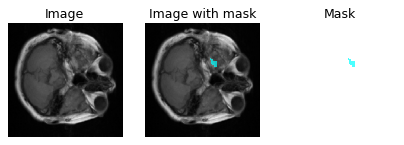

In [ ]:
import matplotlib.pyplot as plt
import numpy.ma as ma

fig=plt.figure(figsize=(130, 130), dpi = 75)

X_batch, Y_batch = next(valid_generator)
while np.sum(Y_batch) < 100:
    X_batch, Y_batch = next(valid_generator)
#print(np.sum(Y_batch))
img = X_batch[0,:,:,0]
Y = Y_batch[0,:,:,0]
print(np.sum(Y))
#print(np.unique(Y))

mask = ma.masked_where(Y == 0, Y)
print(np.unique(Y))
    
fig.add_subplot(3, 3, 1)
plt.imshow(img, cmap = "gray")
plt.title("Image")
plt.axis('off')

fig.add_subplot(3, 3, 2)
plt.imshow(img, cmap = "gray")
plt.imshow(mask, 'cool', alpha=0.7)
plt.title("Image with mask")
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(mask, 'cool', alpha=0.7)
plt.title("Mask")
plt.axis('off')
    
plt.subplots_adjust(bottom=0.1, left = 0.01, right=0.05, top=0.3)
plt.show()
#print(Y)
#i=i+1

Train the particular model we are testing

In [ ]:
import segmentation_models as sm
import tensorflow

num_epochs = 35

batch_size = 16

BACKBONE = 'inceptionv3'

base_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')
inp = Input(shape=(256, 256, 1))
l1 = Conv2D(3, (1, 1)) (inp)
out = base_model(l1)

num_train_samples = 48108
num_valid_samples = 13397

model = Model(inp, out, name = base_model.name)
#model = build_model()
#model = Deeplabv3(input_shape=(256, 256, 1), classes = 1, weights = None, activation = 'sigmoid')
checkpointer = ModelCheckpoint('model_inception_3d.h5', verbose=1, save_best_only=True)
#model.load_weights('model_densenet.h5')
model.compile(optimizer = Adam(lr = 1e-4), loss=dice_loss, metrics=[dice_coeff])
steps_per_epoch = int(np.ceil(num_train_samples/batch_size))
validation_steps = np.ceil(num_valid_samples/batch_size)
results = model.fit_generator(train_generator, validation_data = valid_generator, validation_steps = validation_steps, steps_per_epoch=steps_per_epoch, epochs = num_epochs, callbacks = [checkpointer])

Epoch 1/35
1439/3007 [=============>................] - ETA: 1:55:19 - loss: 0.9738 - dice_coeff: 0.0262

Test the particular model we are testing, by calculating the dice score from the predicted masks, and displaying several examples containing predicted masks and corresponding ground truth masks

1967/1967 [==============================] - 12s 6ms/step


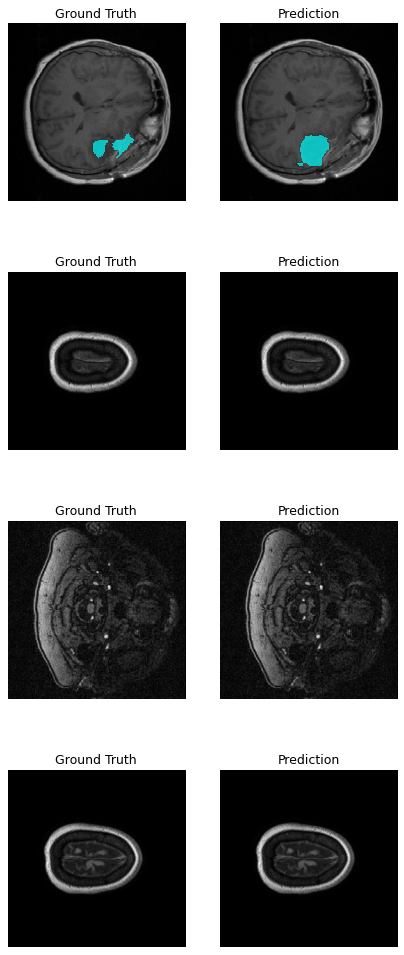

The dice score for this model is:  0.677206227303529


In [ ]:
model.load_weights('./model_seeg_inception.h5')
preds_test = model.predict(X_valid_seg, verbose=1)
preds_test = (preds_test > 0.5).astype(np.uint8)

def np_dice(true, pred):
    intersection = np.sum(true * pred)
    dc =(2.0 * intersection) / (np.sum(true) + np.sum(pred))
    return dc

fig=plt.figure(figsize=(130, 130), dpi = 75)

i=0
for j in range(0,8,2):
    while np.sum(X_valid_seg[i,:,:,0]) < 50:
        i = i+1
    #print(i)
    X = X_valid_seg[i,:,:,0]
    Y = Y_valid_seg[i,:,:,0]
    mask = ma.masked_where(Y == 0, Y)
    pred = preds_test[i,:,:,0]
    pred = ma.masked_where(pred == 0, pred)
    
    fig.add_subplot(8, 2, j+1)
    plt.imshow(X, cmap = "gray")
    plt.imshow(mask, 'cool', alpha=0.7)
    plt.title("Ground Truth")
    plt.axis('off')
    
    fig.add_subplot(8, 2, j+2)
    plt.imshow(X, cmap = "gray")
    plt.imshow(pred, 'cool', alpha=0.7)
    plt.title("Prediction")
    plt.axis('off')
    i = i+1
    
plt.subplots_adjust(bottom=0.1, left = 0.01, right=0.05, top=0.3)
plt.show()

print("The dice score for this model is: ", np_dice(Y_valid_seg, preds_test))

Run this to reset variables when debugging

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
